In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor

dt = 0.2 # Time step
Cb1 = 24.9  # Example concentration for stream 1
Cb2 = 0.1  # Example concentration for stream 2
k1 = 1   # Reaction rate constant
k2 = 1   # Reaction rate parameter

# Initial conditions
h0 = 100.0  # Initial value of h(t)
Cb0 = 21 # Initial value of Cb(t)

# Time span
t_span = (0, 5000)  

### CSTR - Training data & ANN

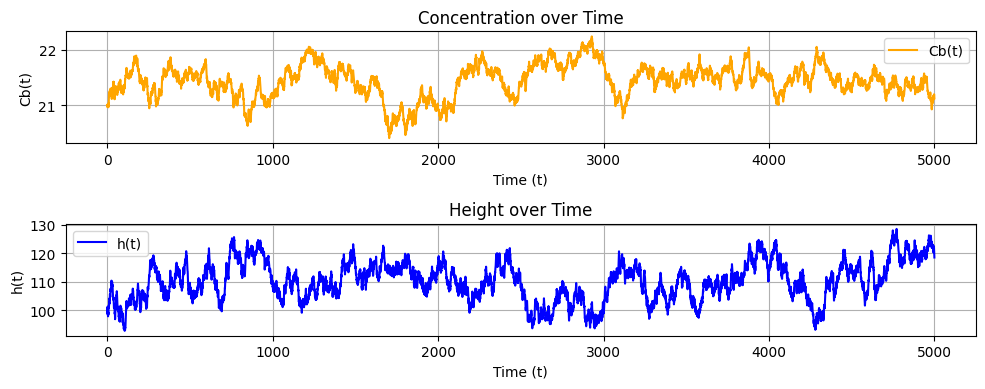

In [2]:
# Define the system of ODEs
def system(t, y):
    h, Cb = y
    h = max(h, 0)  # Ensure that h is non-negative
    dh_dt = w1(t) + w2(t) - 0.2 * np.sqrt(h) 
    epsilon = 1e-6  # Small value to avoid division by zero
    dCb_dt = ((Cb1 - Cb) * w1(t) / (h + epsilon) + (Cb2 - Cb) * w2(t) / (h + epsilon) - k1 * Cb / (1 + k2 * Cb)**2) 
    return [dh_dt, dCb_dt]

def w1(_):
    return np.random.uniform(0, 4)  # Example random flow rate

def w2(_):
    return 0.1  # Example constant flow rate

# Time span for the simulation
t_eval = np.arange(t_span[0], t_span[1], dt)  # Time points for evaluation

# Solve the ODEs
solution = solve_ivp(system, t_span, [h0, Cb0], t_eval=t_eval)

# Plot the results using subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 4))

# Plot Cb(t)
axs[0].plot(solution.t, solution.y[1], label='Cb(t)', color='orange')
axs[0].set_xlabel('Time (t)')
axs[0].set_ylabel('Cb(t)')
axs[0].set_title('Concentration over Time')
axs[0].legend()
axs[0].grid()

# Plot h(t)
axs[1].plot(solution.t, solution.y[0], label='h(t)', color='blue')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('h(t)')
axs[1].set_title('Height over Time')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


In [3]:
df = pd.DataFrame({'Time': solution.t, 'w1': [w1(t) for t in t_eval], 'Cb(t)': solution.y[1]})
print(df.shape)
df.head(3)

(25000, 3)


,Time,w1,Cb(t)
0,0.0,3.358040,21.000000
1,0.2,2.352650,20.994544
2,0.4,3.198189,20.990873


In [4]:
def prediction_plot(testY, test_predict) -> None:
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(12,3))
    plt.plot(len_prediction, testY, marker='.', label="actual")
    plt.plot(len_prediction, test_predict, 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()
    
def convert2matrix(data_arr, look_back) -> tuple:
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,1:])
        Y.append(data_arr[d,2])
    return np.array(X), np.array(Y)

train_size = int(len(df) * 0.70)
train, test = df.values[0:train_size,:],df.values[train_size:len(df.values),:]
look_back = 1
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

# Reshape trainX and trainY to the shape of [samples, features]
trainX = np.reshape(trainX, (trainX.shape[0], 2))
testX = np.reshape(testX, (testX.shape[0], 2))

trainY = np.reshape(trainY, (trainY.shape[0],))
testY = np.reshape(testY, (testY.shape[0],))

print('Train and Test Shapes:')
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

Train and Test Shapes:
(17499, 2) (17499,) (7499, 2) (7499,)


In [5]:
# Create the MLP model
model = MLPRegressor(hidden_layer_sizes=(64, 64, 64), max_iter=1000, activation='relu', solver='adam', learning_rate_init=0.01, verbose=True)
model.fit(trainX, trainY)

Iteration 1, loss = 5.44752708
Iteration 2, loss = 0.00014107
Iteration 3, loss = 0.00014300
Iteration 4, loss = 0.00014858
Iteration 5, loss = 0.00014238
Iteration 6, loss = 0.00014342
Iteration 7, loss = 0.00014981
Iteration 8, loss = 0.00013883
Iteration 9, loss = 0.00014171
Iteration 10, loss = 0.00014533
Iteration 11, loss = 0.00015617
Iteration 12, loss = 0.00015401
Iteration 13, loss = 0.00014718
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPRegressor(hidden_layer_sizes=(64, 64, 64), learning_rate_init=0.01,
             max_iter=1000, verbose=True)

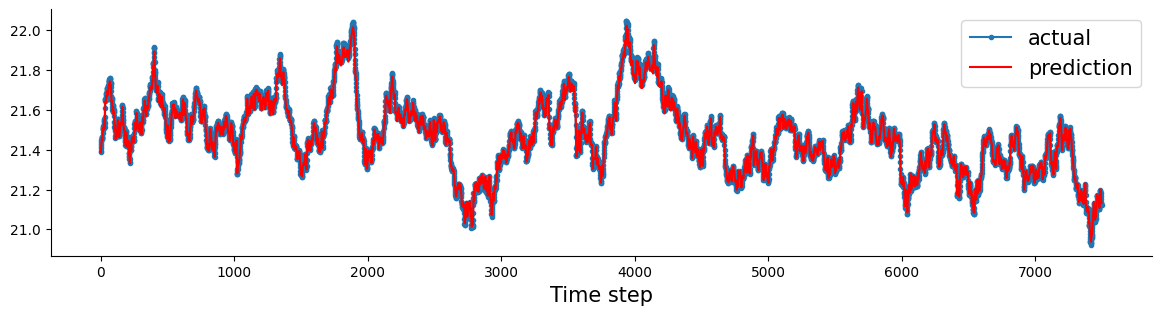

In [6]:
y_pred = model.predict(testX)
prediction_plot(testY, y_pred)

### Model Predictive Control

In [7]:
N_1 = 1
N_2 = 7
N_u = 2
rho = 0.05
alpha = 0.001

def set_point(t):
    if t <= 38: 
        return 20.9
    elif t <= 58:
        return 23
    elif t <= 85:
        return 22.5
    else:
        return 21.5

In [8]:
def cost_function(p_seq, y_init, t):
    y_pred = y_init
    J = 0.0
    for j in range(N_1, N_2):
        p = p_seq[min(j, N_u - 1)]
        y_pred = model.predict([[p, y_pred]])[0]
        
        # SP 
        SP = 20.9 if t <= 38 else 23 if t <= 58 else 22.5 if t <= 85 else 21.5
                
        J += (y_pred - SP)**2 
    for j in range(1, N_u):
        J += rho * (p_seq[j] - p_seq[j - 1])**2  # Add squared control difference
    return J

def mpc_control(y, t):
    # p_init = np.linspace(0, 4, N_2)
    p_init = np.random.uniform(0, 4, N_2)
    result = minimize(cost_function, p_init, args=(y, t), bounds=[(0.1, 4)]*N_2)
    return result.x[0] if result.success else 0.0

# Simulation
time = np.arange(0, 120, dt)
y = 22
outputs = []
controls = []

for t in tqdm(range(len(time))):
    p_opt = mpc_control(y, t * dt)
    
    outputs.append(y)
    controls.append(p_opt)
    
    y = model.predict([[p_opt, y]])[0]

100%|██████████| 600/600 [02:23<00:00,  4.19it/s]


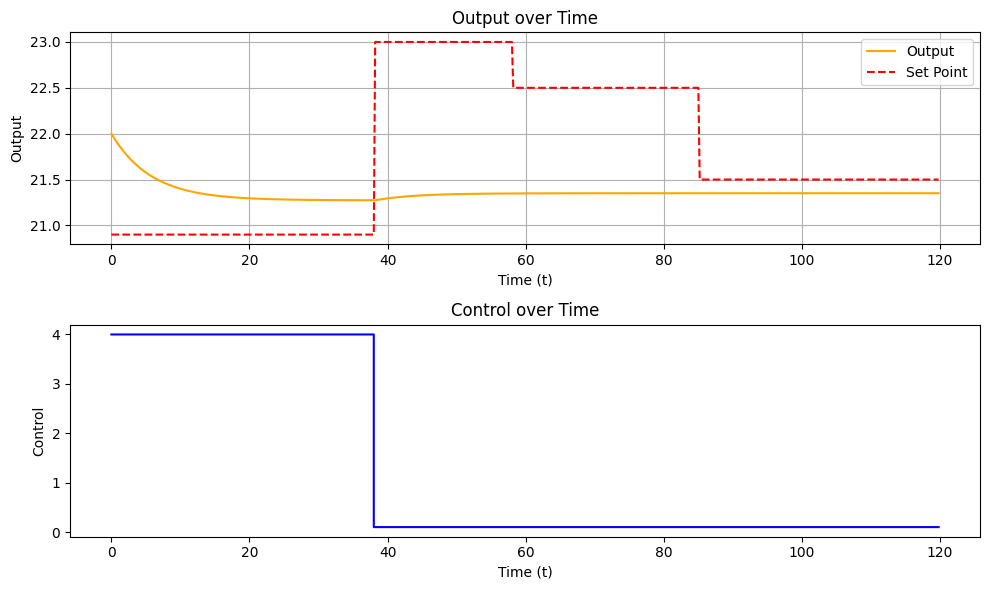

In [9]:
df = pd.DataFrame({'Time': time, 'Output': outputs, 'Control': controls})

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plot the output
axs[0].plot(df['Time'], df['Output'], label='Output', color='orange')
axs[0].plot(df['Time'], [set_point(t) for t in time], label='Set Point', color='red', linestyle='--')
axs[0].set_xlabel('Time (t)')
axs[0].set_ylabel('Output')
axs[0].set_title('Output over Time')
axs[0].legend()
axs[0].grid()

# Plot the control
axs[1].step(df['Time'], df['Control'], label='Control', color='blue')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('Control')
axs[1].set_title('Control over Time')

plt.tight_layout()
plt.show()
